Show good correlation

Super large groups have higher influence, but smaller groups can also have influence in balanced data

Accuracy doesn't correlate with nonfires influence: bad acc = pos predictor, high acc = neg predictor; which group is good/bad can flip depending on class balance

Test set (covered + nonfires) influence (anti)correlates with nonfires influence, depending on the previous statement.


Manually examine:

High or low infl LFs: self, nonfire




In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals

import sys
sys.path.insert(1,'/u/nlp/packages/anaconda2/lib/python2.7/site-packages/')
import pandas as pd

from experiments.data_valuation import *
from datasets.babble import *

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import collections
import re
from matplotlib import colors as mcolors
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr

import IPython

sns.set()

In [2]:
def load_data(exp_num):
    exp_ids = ['reduced_cdr_sample_weights-True-bal-nonfires-bal-test',
               'reduced_cdr_sample_weights-True',
               'reduced_cdr_sample_weights-True-bal-nonfires',
               'reduced_spouse_sample_weights-True',
               'reduced_spouse_sample_weights-True-bal-nonfires',
              ]
    exp_id = exp_ids[exp_num]
    print('Experiment {}'.format(exp_id))
    exp = DataValuation.load_run(exp_id, out_dir='/u/nlp/influence/output/')
    return exp_id, exp

def normalize(data):
    return np.array([data[i]/subset_sizes[i] for i in range(num_groups)])*max(subset_sizes)

def percent_pos(dataset):
    return sum(dataset.labels == 1)/len(dataset.labels)
    
def calcR(x, y):
    return pearsonr(x, y)[0]
    
def printR(x, y, x_lab, y_lab):
    print('Pearson\'s R between {} and {} is {}'.format(x_lab, y_lab, calcR(x,y)))

def line():
    print('-----------------------------')
    
def stem(ax, y, posInds, negInds, y_lab, title=None):
    n = len(y)
    ax.stem(np.array(range(n))[posInds]+1, y[posInds], label='pos', linefmt='b', markerfmt='bo')
    ax.stem(np.array(range(n))[negInds]+1, y[negInds], label='neg', linefmt='g', markerfmt='go')
    ax.set_xlabel('LF id')
    ax.set_ylabel(y_lab)
    if title is not None:
        ax.set_title(title)
    ax.legend()

def hist(ax, x, x_lab, bins=10, title=None):
    ax.hist(x, bins=bins)
    ax.set_xlabel(x_lab)
    ax.set_ylabel('Frequency')
    if title is not None:
        ax.set_title('Group influence on set of nonfires\n{}'.format(ds_name))
    #ax.savefig('reduced_spouse_avg_subset_nonfires_pred_infl_bal_nonfires_distrib.png',dpi=300)
    
def scatter(ax, x, y, posInds, negInds, x_lab, y_lab, title=None):
    ax.scatter(x[posInds], y[posInds], label='pos', c='b')
    ax.scatter(x[negInds], y[negInds], label='neg', c='g')
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)
    ax.legend()
    if title is not None:
        ax.set_title(title)
    print(pearsonr(x,y)[0])

In [5]:
exp_id, exp = load_data(1)
ds_name = exp.config['dataset_config']['dataset_id']
mask = (exp.R['subset_tags'] == 'same_features')
num_groups = sum(mask)

nonfires = exp.nonfires
LF_labels, gold_labels = load_cdr_labeling_info(data_dir='/u/nlp/influence/data/')
ex_id_to_gold = dict(zip(gold_labels[:,1],gold_labels[:,0]))
ex_id_to_LF_lab = [dict(zip(LF_labels[np.where(LF_labels[:,2]==i)[0],1],
                           LF_labels[np.where(LF_labels[:,2]==i)[0],0])) for i in range(1,num_groups+1)]
accs = []
class_pos, class_neg = [], []
for i in range(num_groups):
    y_pred, y_true = [], []
    for key, val in ex_id_to_LF_lab[i].iteritems():
        y_pred.append(val)
        y_true.append(ex_id_to_gold[key])
    if y_pred[0] > 0: class_pos.append(i)
    else: class_neg.append(i)
    accs.append(sum(np.array(y_true) == np.array(y_pred))/len(y_true))
accs = np.array(accs)
    
subset_sizes = np.array([len(a) for a in exp.R['subset_indices'][mask]])
subset_self_pred_infl = exp.R['subset_self_pred_infl'][mask]
subset_test_set_pred_infl = exp.R['subset_all_test_pred_infl'][mask]
subset_pos_test_pred_infl = exp.R['subset_pos_test_pred_infl'][mask]
subset_neg_test_pred_infl = exp.R['subset_neg_test_pred_infl'][mask]
subset_train_set_pred_infl = exp.R['subset_all_train_pred_infl'][mask]
nonfires_preds = exp.R['nonfires_predictions']
subset_nonfires_pred_infl = exp.R['subset_nonfires_pred_infl'][mask]

nonfires_pos = np.where(exp.nonfires.labels == 1)[0]
nonfires_neg = np.where(exp.nonfires.labels == 0)[0]
avg_subset_nonfires_pred_infl_pos = np.mean(subset_nonfires_pred_infl[:,nonfires_pos], axis=1)
avg_subset_nonfires_pred_infl_neg = np.mean(subset_nonfires_pred_infl[:,nonfires_neg], axis=1)
avg_subset_nonfires_pred_infl = np.mean(subset_nonfires_pred_infl, axis=1)

meta = [subset_sizes, accs]
meta_names = ['Subset size', 'Accuracy']
infls = [subset_self_pred_infl, subset_train_set_pred_infl, # subset_test_set_pred_infl,
         subset_pos_test_pred_infl, subset_neg_test_pred_infl,\
         avg_subset_nonfires_pred_infl, avg_subset_nonfires_pred_infl_pos, avg_subset_nonfires_pred_infl_neg]
infls_names = ['Self pred infl', 'Tot train set pred infl', # 'Tot test set pred infl',
               'Pos test set pred infl', 'Neg test set pred infl',\
              'Avg nonfires pred infl', 'Avg pos nonfires pred infl', 'Avg neg nonfires pred infl']
normalized_infls = [normalize(x) for x in infls[1:]]
normalized_infls_names = [s + ' normalized' for s in infls_names[1:]]

print('Train is {} positive'.format(percent_pos(exp.train)))
print('Test is {} positive'.format(percent_pos(exp.test)))
print('Nonfires is {} positive'.format(percent_pos(exp.nonfires)))

Experiment reduced_cdr_sample_weights-True
Retrieving reduced cdr.
Loaded reduced cdr.
Loading cdr weights from /u/nlp/influence/data/babble/cdr_weights.npz.
Loaded cdr weights.
Retrieving reduced cdr nonfires.
Loaded reduced cdr nonfires.
Loading phase 0-cross_validation from previous run:
/u/nlp/influence/output/data_valuation/reduced_cdr_sample_weights-True/result_0-cross_validation.npz
Loading phase 1-initial_training from previous run:
/u/nlp/influence/output/data_valuation/reduced_cdr_sample_weights-True/result_1-initial_training.npz
Loading phase 2-pick_test_points from previous run:
/u/nlp/influence/output/data_valuation/reduced_cdr_sample_weights-True/result_2-pick_test_points.npz
Loading phase 3-hessian from previous run:
/u/nlp/influence/output/data_valuation/reduced_cdr_sample_weights-True/result_3-hessian.npz
Loading phase 4-all_and_fixed_test_and_nonfire_influence from previous run:
/u/nlp/influence/output/data_valuation/reduced_cdr_sample_weights-True/result_4-all_and_fi

Pearson's R between Subset size and Self pred infl is 0.903920708749
0.903920708749
Pearson's R between Subset size and Tot train set pred infl is 0.49422768043
0.49422768043
Pearson's R between Subset size and Pos test set pred infl is 0.0148818794694
Pearson's R between Subset size and Neg test set pred infl is -0.0126511815054
Pearson's R between Subset size and Avg nonfires pred infl is -0.00703850849422
Pearson's R between Subset size and Avg pos nonfires pred infl is 0.0639054614043
Pearson's R between Subset size and Avg neg nonfires pred infl is -0.00866123557849
Pearson's R between Accuracy and Self pred infl is -0.180290560875
Pearson's R between Accuracy and Tot train set pred infl is -0.269875139272
Pearson's R between Accuracy and Pos test set pred infl is -0.438060061588
-0.438060061588
Pearson's R between Accuracy and Neg test set pred infl is 0.465904141173
0.465904141173
Pearson's R between Accuracy and Avg nonfires pred infl is 0.326859375919
Pearson's R between Accur

/u/nlp/packages/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0.942652273474
Pearson's R between Neg test set pred infl and Avg pos nonfires pred infl is -0.930881594114
-0.930881594114
Pearson's R between Neg test set pred infl and Avg neg nonfires pred infl is 0.942537259451
0.942537259451
Pearson's R between Avg nonfires pred infl and Self pred infl is -0.289739468643
Pearson's R between Avg nonfires pred infl and Tot train set pred infl is -0.322247764242
Pearson's R between Avg nonfires pred infl and Pos test set pred infl is -0.967862012446
-0.967862012446
Pearson's R between Avg nonfires pred infl and Neg test set pred infl is 0.942652273474
0.942652273474
Pearson's R between Avg nonfires pred infl and Avg pos nonfires pred infl is -0.991553577964
-0.991553577964
Pearson's R between Avg nonfires pred infl and Avg neg nonfires pred infl is 0.999993165205
0.999993165205
Pearson's R between Avg pos nonfires pred infl and Self pred infl is 0.357488142758
Pearson's R between Avg pos nonfires pred infl and Tot train set pred infl is 0.3448769121

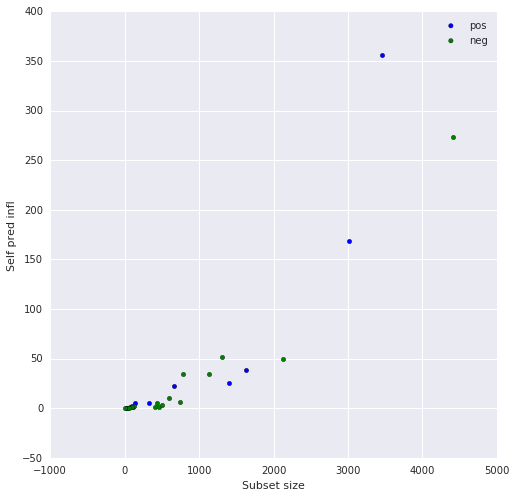

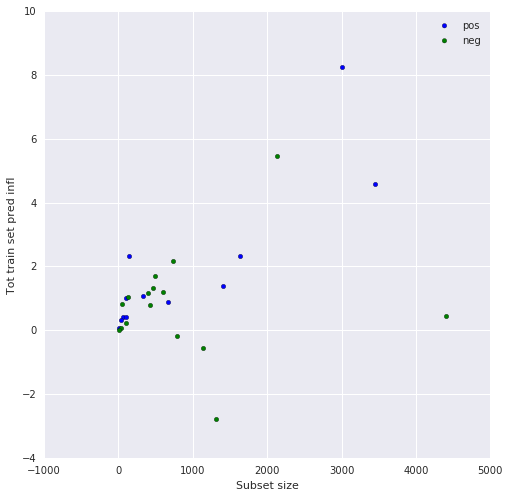

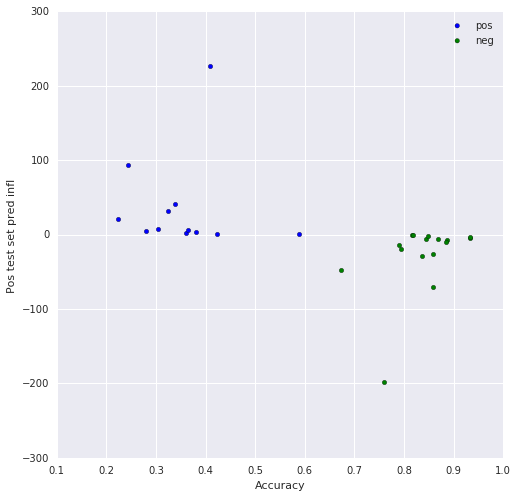

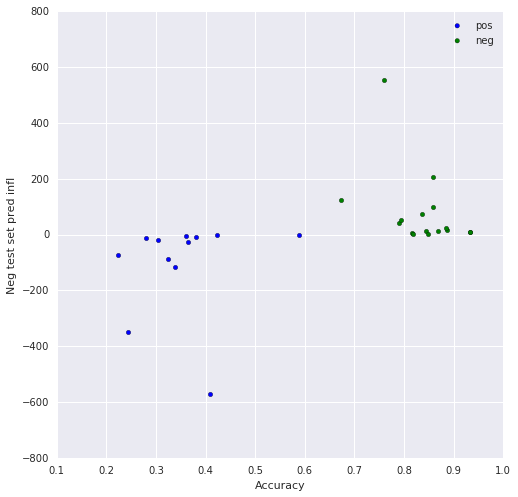

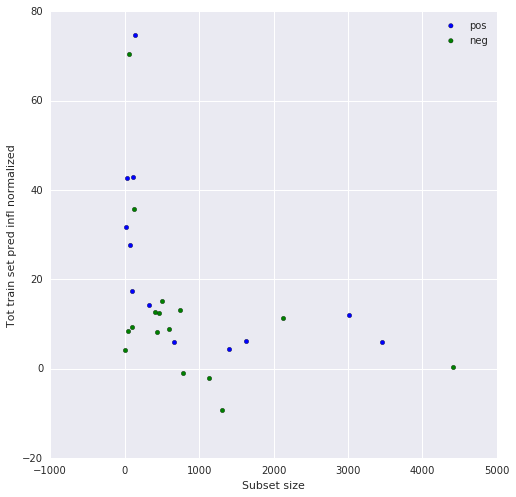

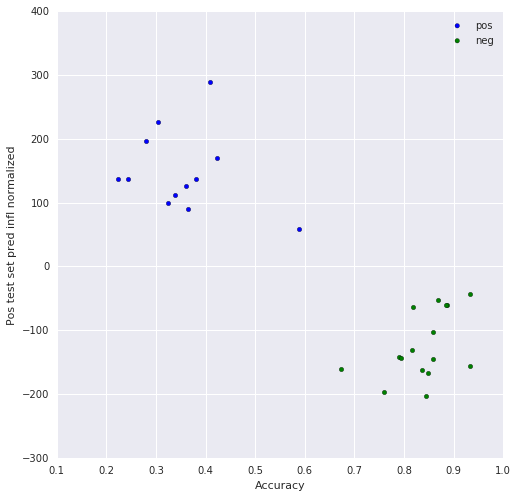

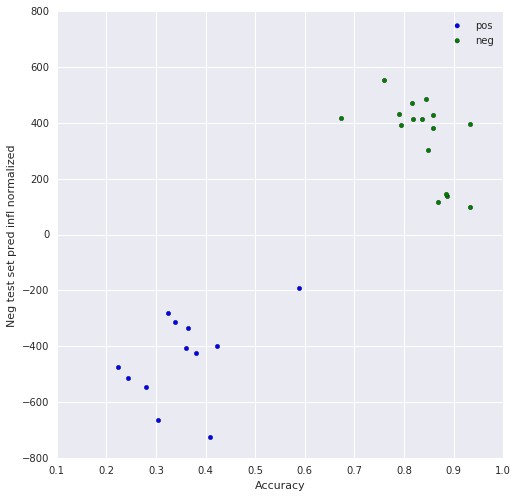

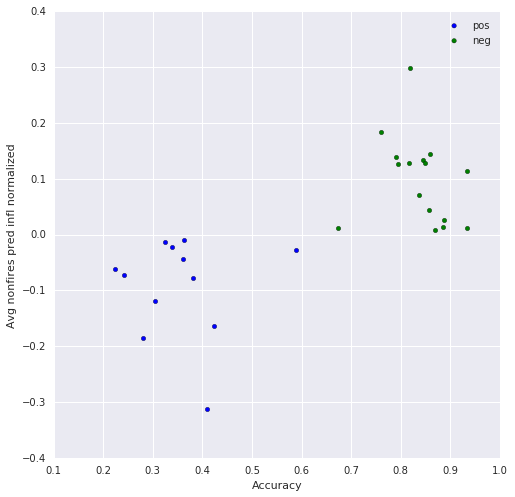

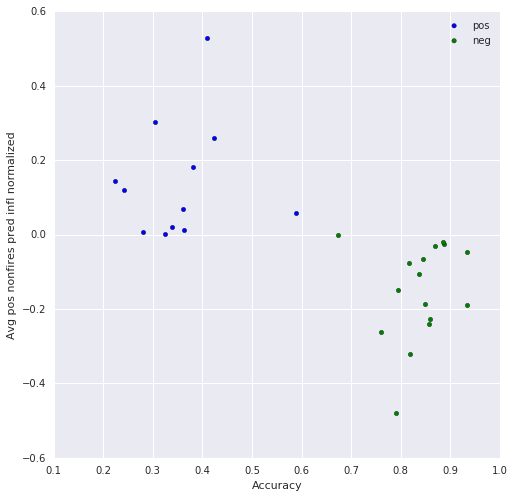

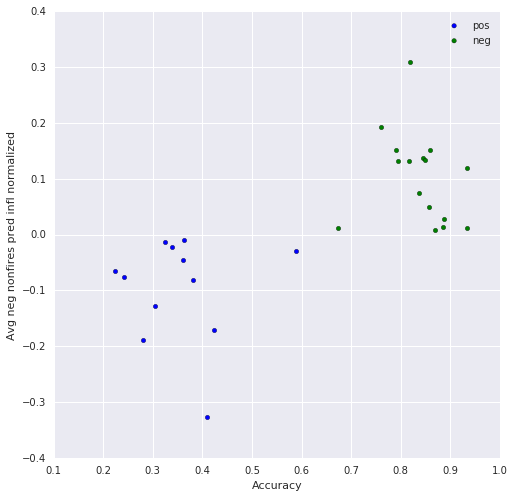

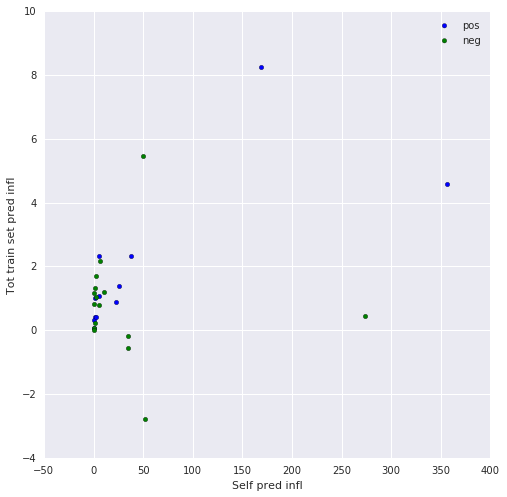

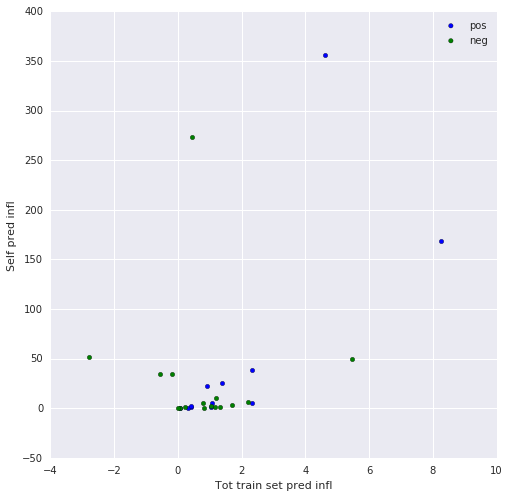

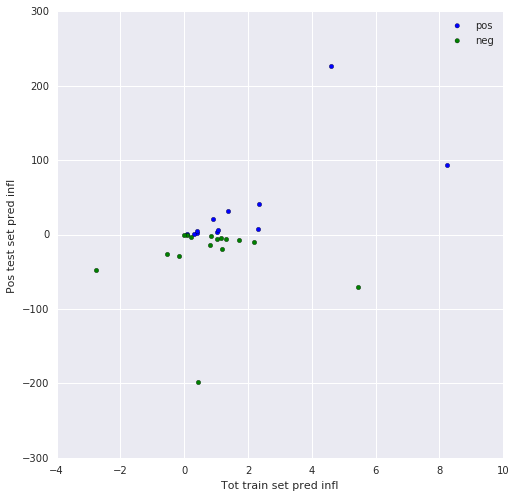

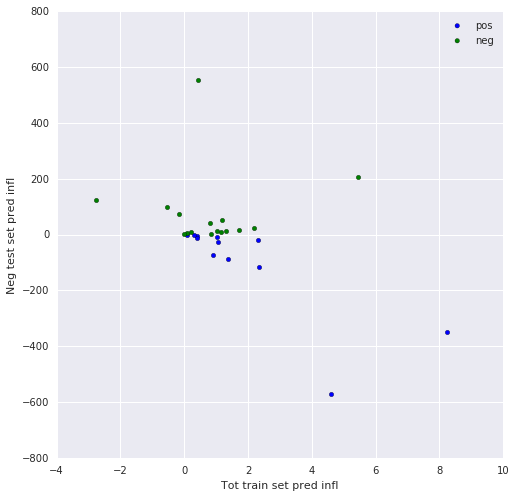

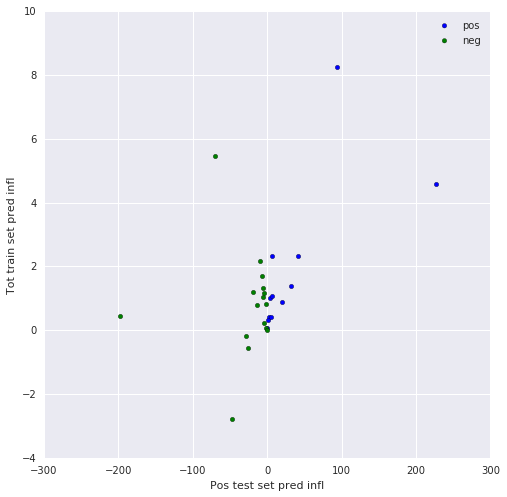

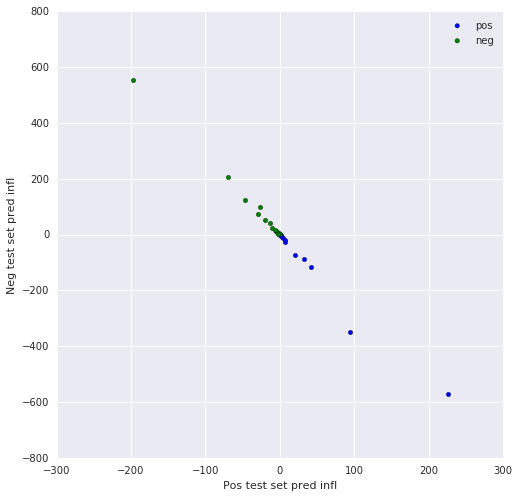

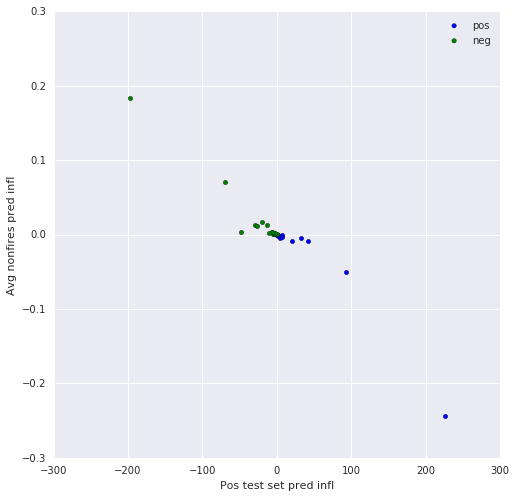

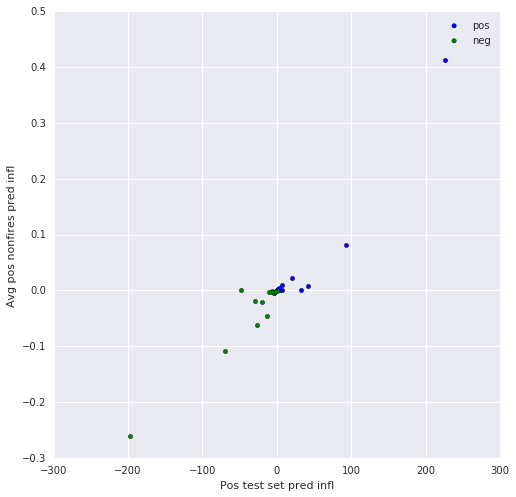

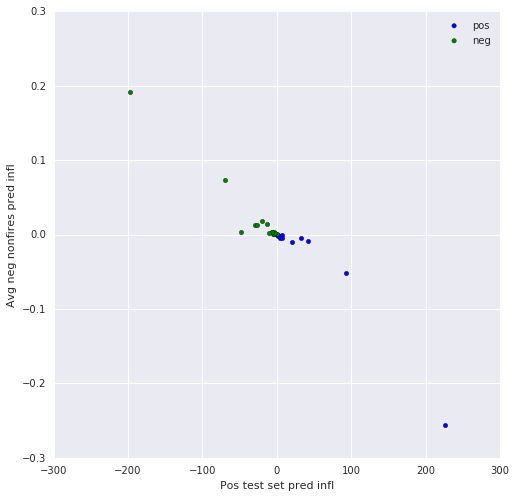

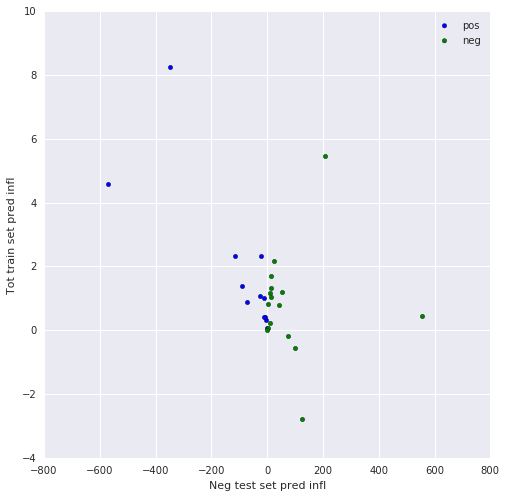

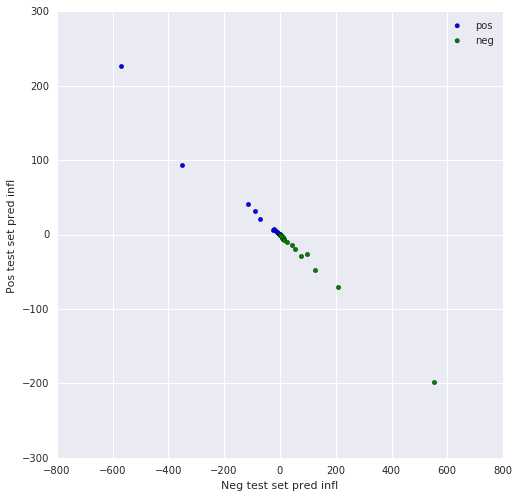

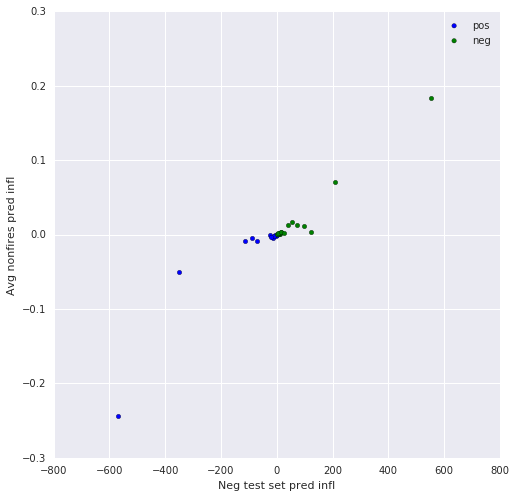

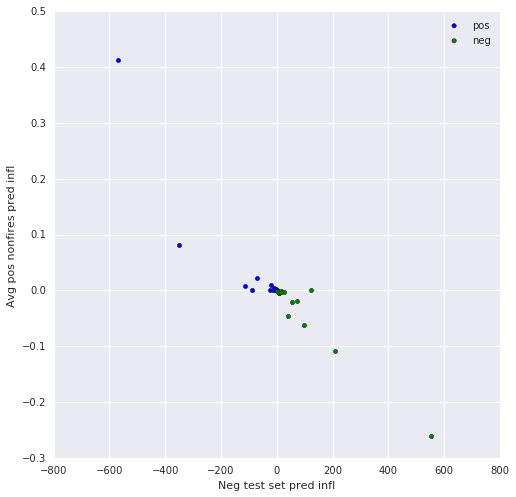

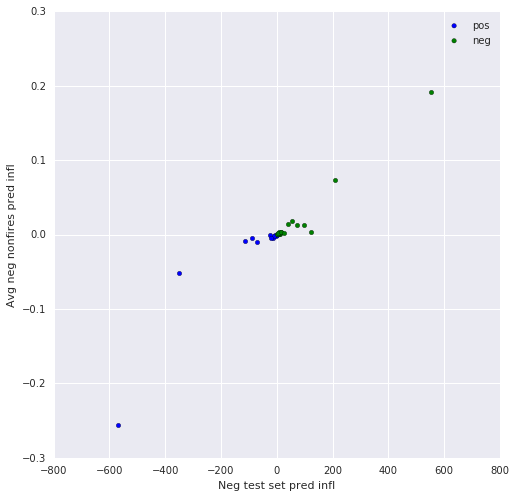

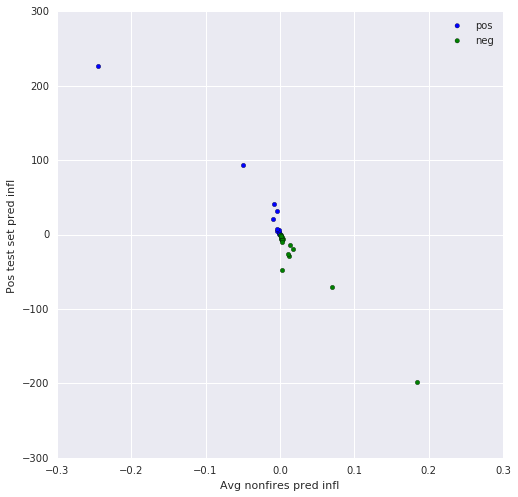

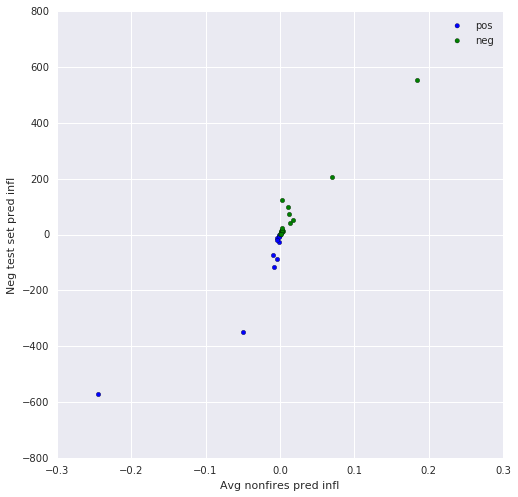

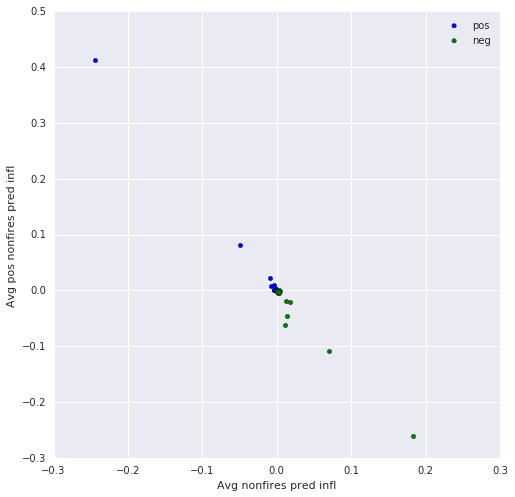

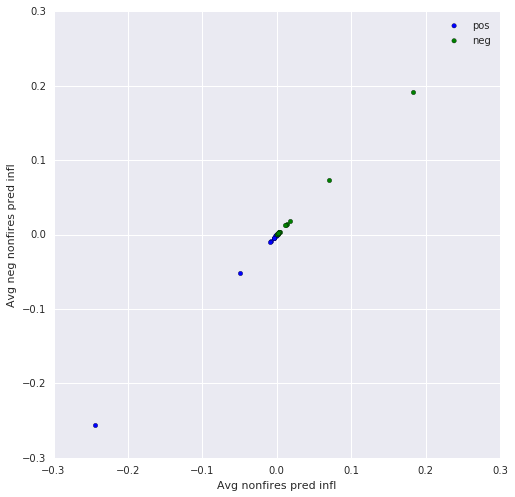

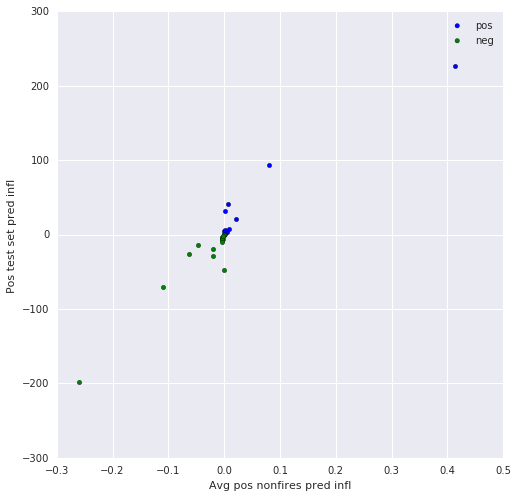

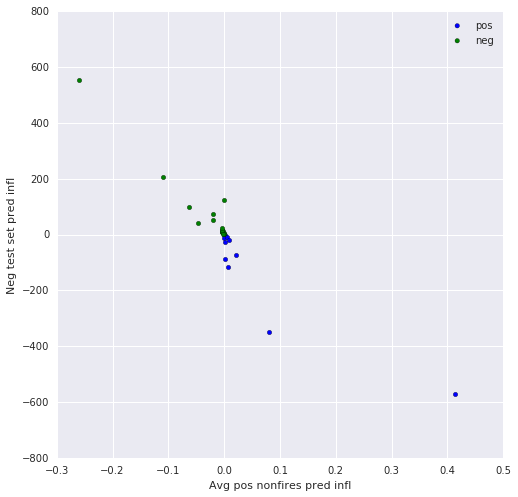

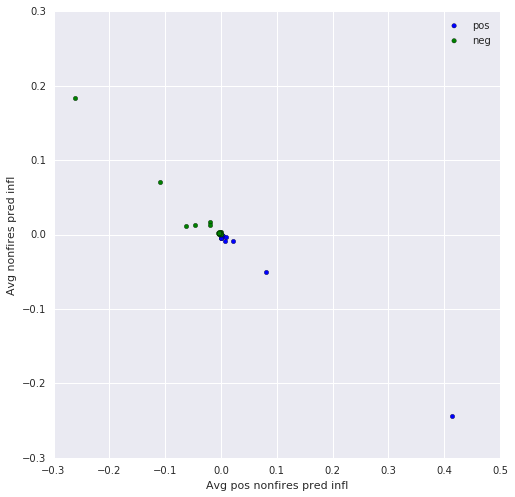

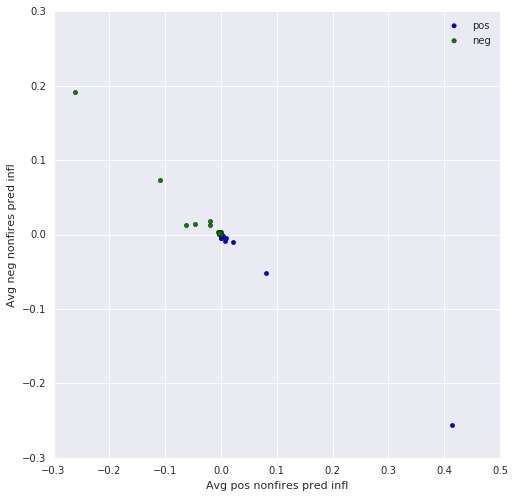

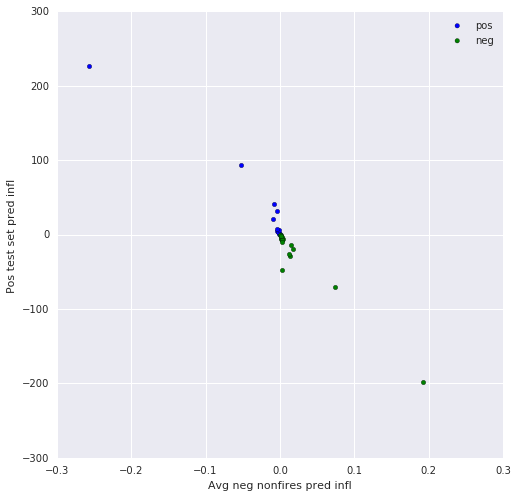

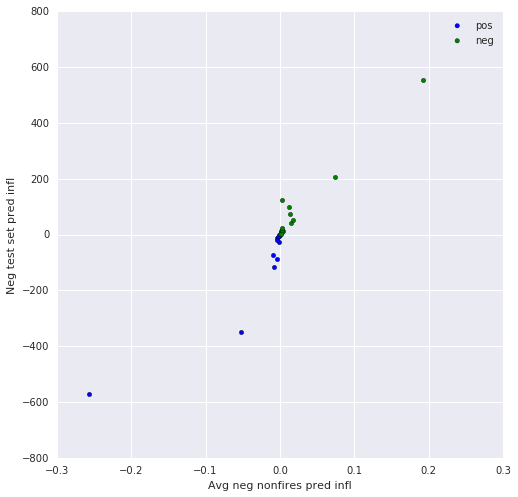

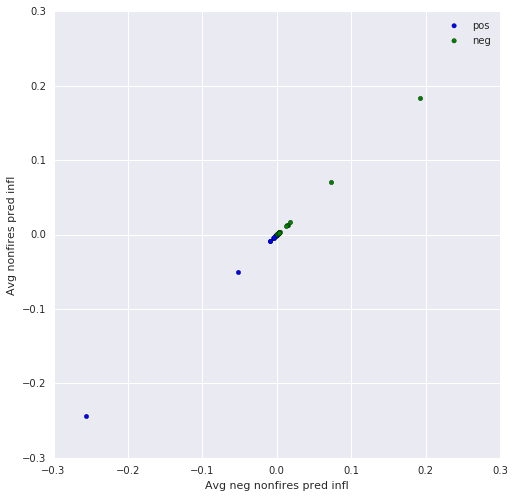

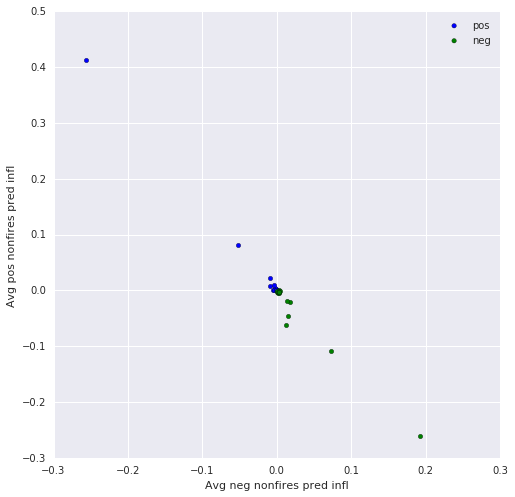

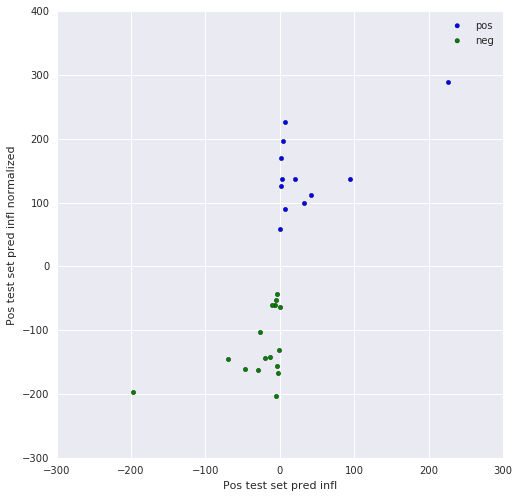

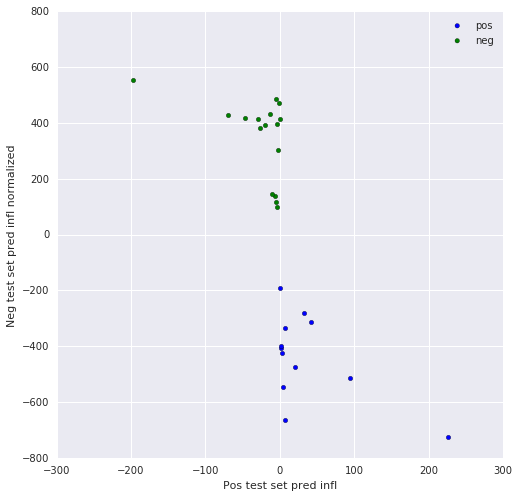

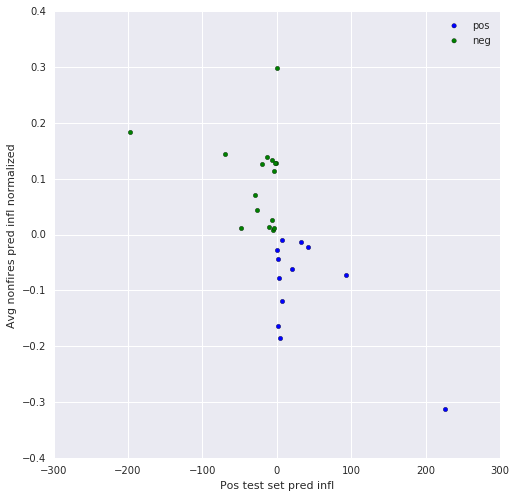

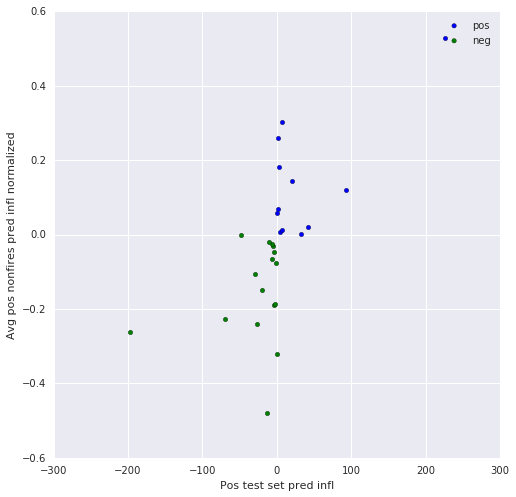

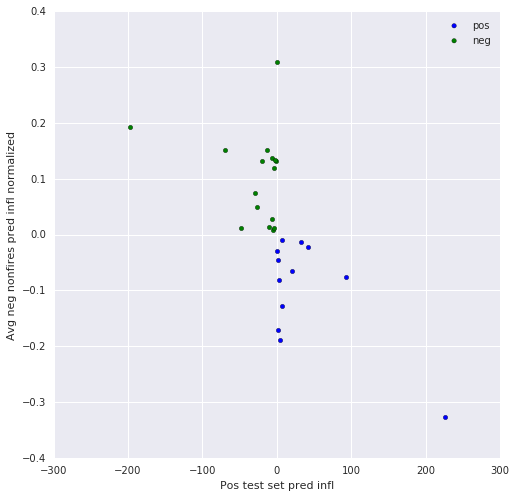

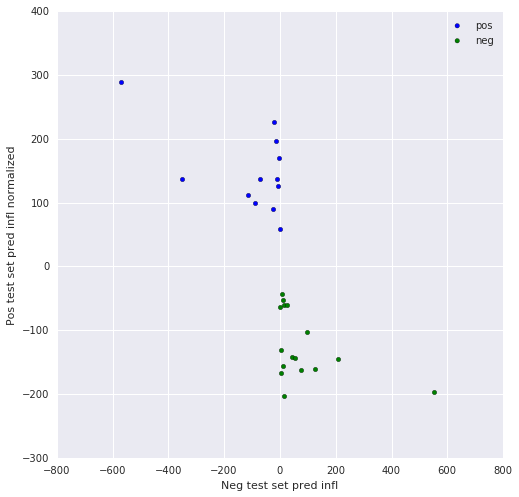

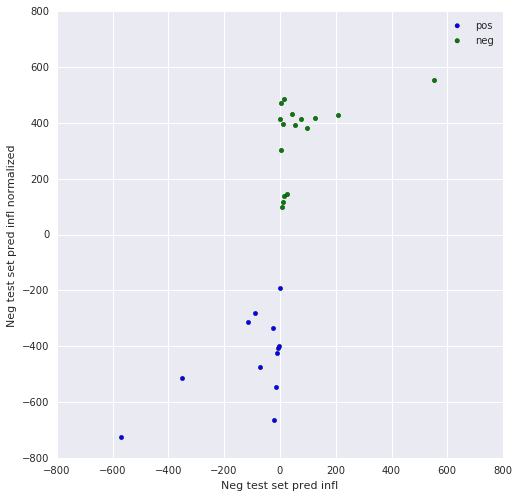

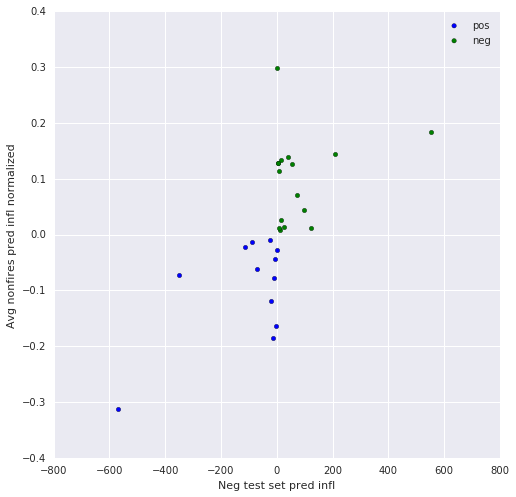

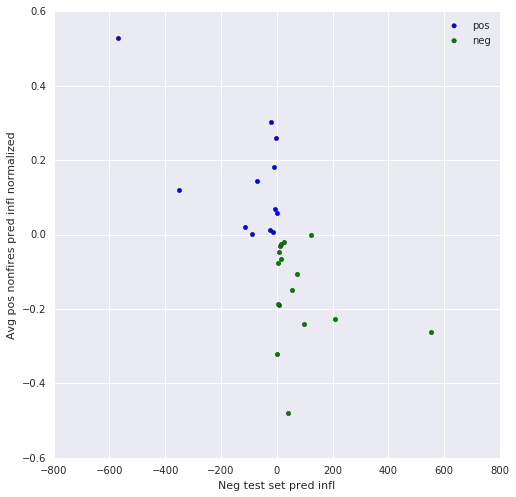

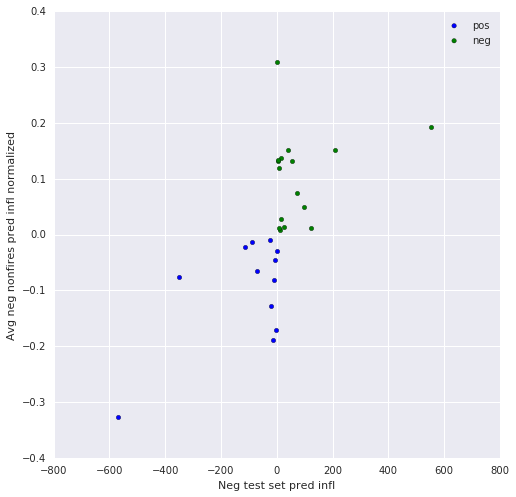

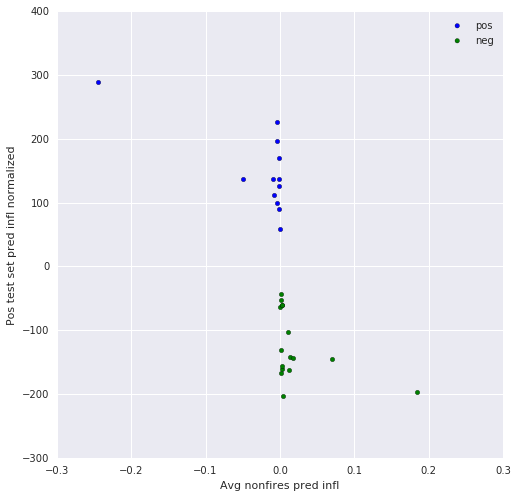

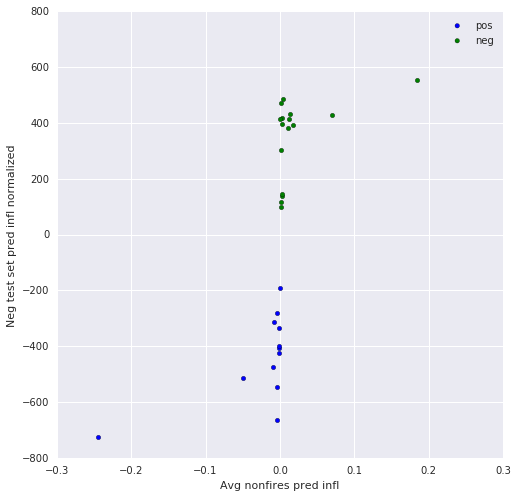

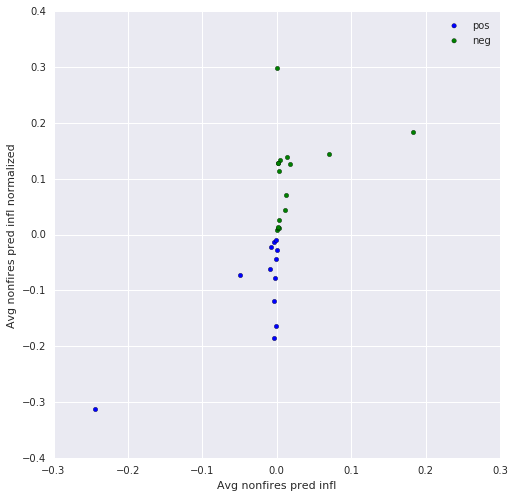

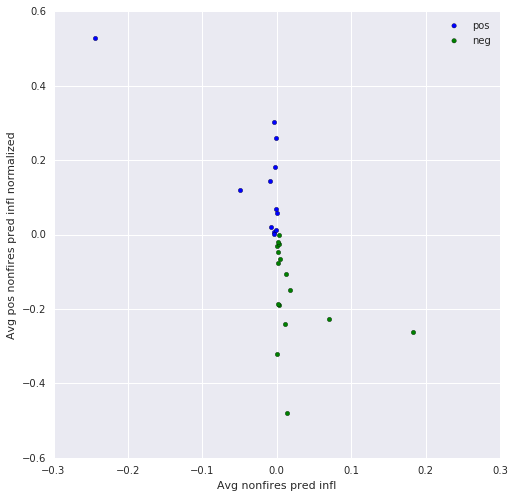

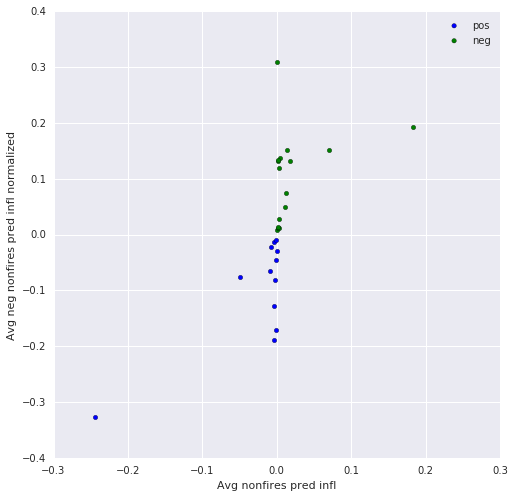

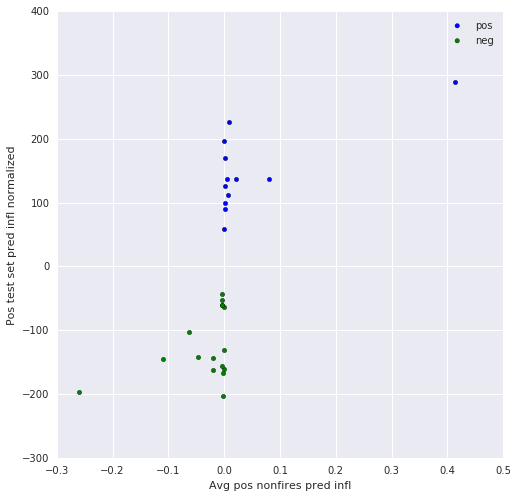

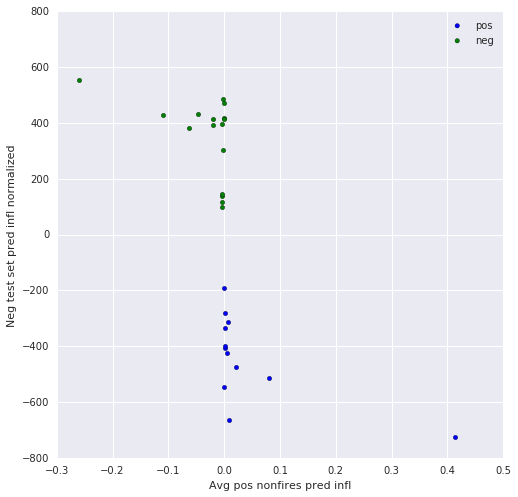

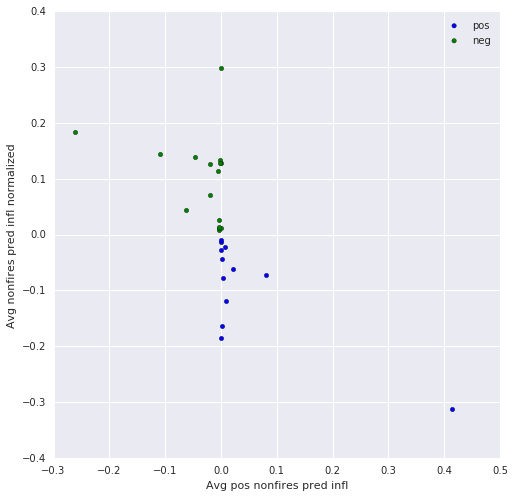

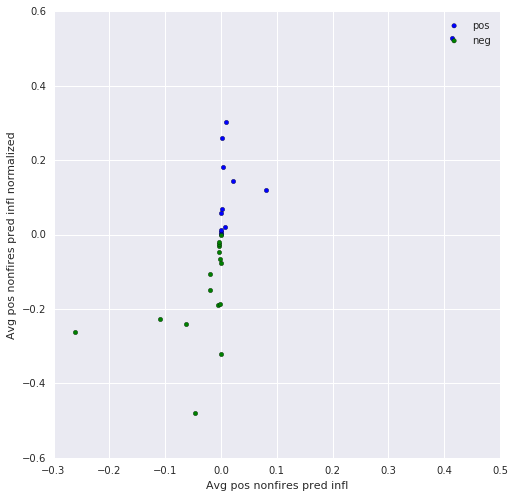

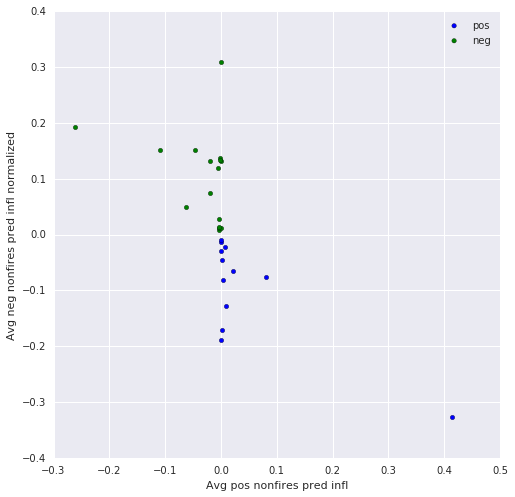

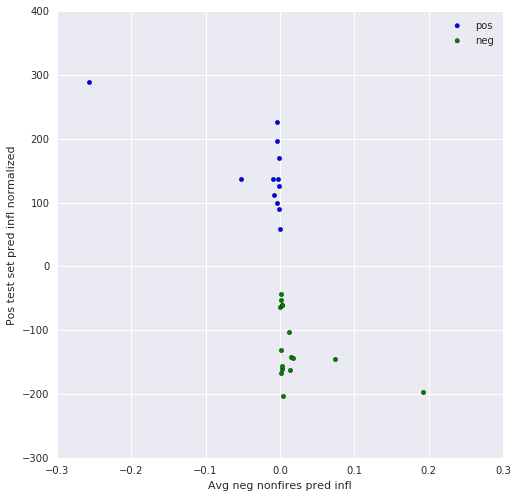

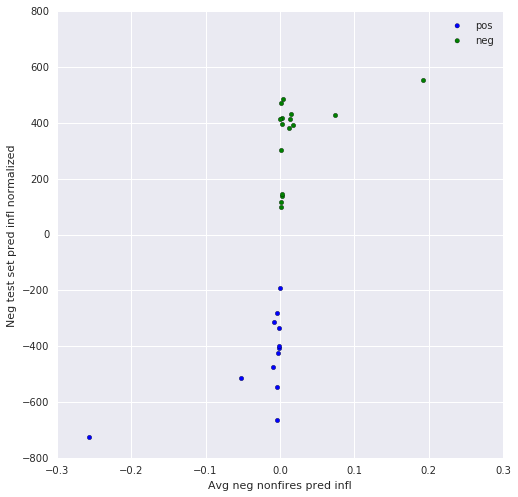

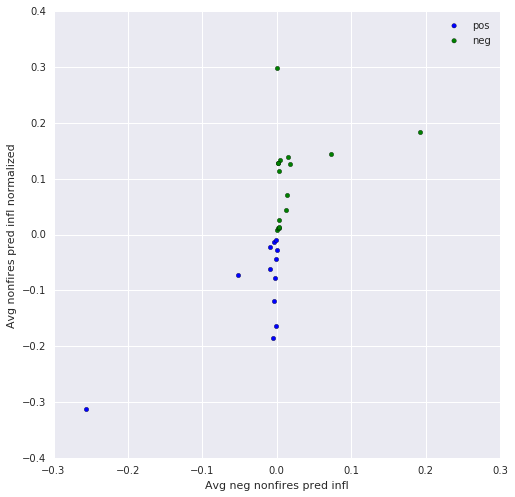

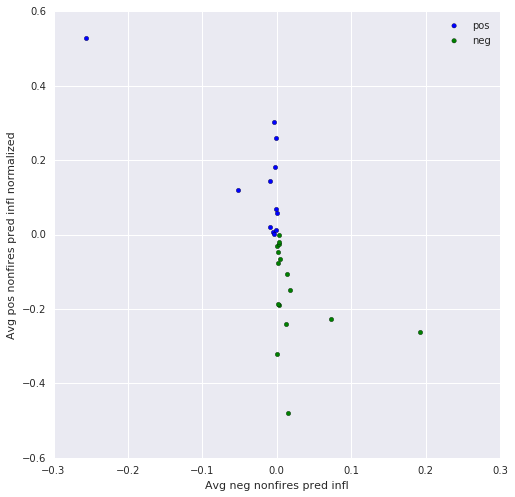

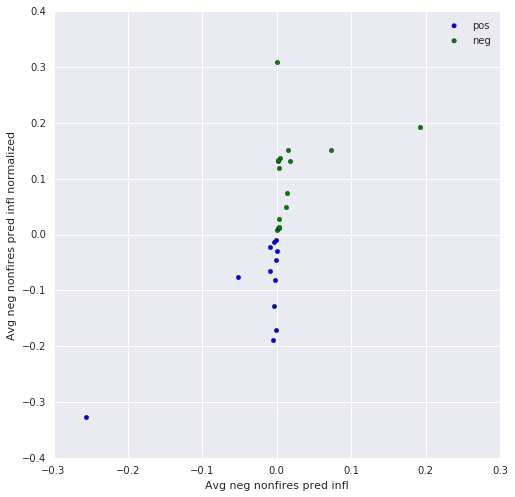

In [6]:
for x, x_name in zip(meta, meta_names):
    for y, y_name in zip(infls, infls_names):
        printR(x, y, x_name, y_name)
        if np.abs(calcR(x, y)) > 0.4:
            fig, ax = plt.subplots(1,1,figsize=(8,8),squeeze=False)
            scatter(ax[0][0], x, y, class_pos, class_neg, x_name, y_name)
line()
for x, x_name in zip(meta, meta_names):
    for y, y_name in zip(normalized_infls, normalized_infls_names):
        printR(x, y, x_name, y_name)
        if np.abs(calcR(x, y)) > 0.4:
            fig, ax = plt.subplots(1,1,figsize=(8,8),squeeze=False)
            scatter(ax[0][0], x, y, class_pos, class_neg, x_name, y_name)
line()
for x, x_name in zip(infls, infls_names):
    for y, y_name in zip(infls, infls_names):
        if x_name != y_name:
            printR(x, y, x_name, y_name)
            if np.abs(calcR(x, y)) > 0.4:
                fig, ax = plt.subplots(1,1,figsize=(8,8),squeeze=False)
                scatter(ax[0][0], x, y, class_pos, class_neg, x_name, y_name)
line()
for x, x_name in zip(infls, infls_names):
    for y, y_name in zip(normalized_infls, normalized_infls_names):
        if x_name != y_name:
            printR(x, y, x_name, y_name)
            if np.abs(calcR(x, y)) > 0.4:
                fig, ax = plt.subplots(1,1,figsize=(8,8),squeeze=False)
                scatter(ax[0][0], x, y, class_pos, class_neg, x_name, y_name)
line()
printR(meta[0], meta[1], meta_names[0], meta_names[1])

In [5]:
plt.close('all')

In [10]:
combos = [(meta[0], meta_names[0], infls[0], infls_names[0]),
          (infls[-2], infls_names[-2], infls[-1], infls_names[-1]),
          (infls[2], infls_names[2], infls[3], infls_names[3])]
for i in range(2,7):
    for j in range(2):
        combos.append((meta[j], meta_names[j], infls[i], infls_names[i]))
for i in range(4,7):
    for j in range(2,4):
        combos.append((infls[j], infls_names[j], infls[i], infls_names[i]))
"""combos = [(meta[0], meta_names[0], infls[2], infls_names[2])]"""
    
for x, x_name, y, y_name in combos:
    fig, ax = plt.subplots(1,1,figsize=(8,8),squeeze=False)
    scatter(ax[0][0], x, y, class_pos, class_neg, x_name, y_name, title='{}, Pearson\'s R: {}'.format(ds_name, calcR(x, y)))
    plt.savefig('{}_{}_vs_{}'.format(ds_name, x_name, y_name), dpi=200)
    plt.close()

0.903920708749
-0.992026323838
-0.992642060577
0.0148818794694
-0.438060061588
-0.0126511815054
0.465904141173
-0.00703850849422
0.326859375919
0.0639054614043
-0.340462295089
-0.00866123557849
0.327323614811
-0.967862012446
0.942652273474
0.955955362508
-0.930881594114
-0.967749020027
0.942537259451


In [8]:
stems = []
for i in range(2):
    stems.append((meta[i], meta_names[i]))
for i in range(2,5):#7):
    stems.append((infls[i], infls_names[i]))
    
for y, y_name in stems:
    fig, ax = plt.subplots(1,1,figsize=(8,8),squeeze=False)
    stem(ax[0][0], y, class_pos, class_neg, y_name, title=ds_name)
    plt.savefig('{}_stem_{}'.format(ds_name, y_name), dpi=200)
    plt.close()